In [14]:
ls Data


 Volume in drive C has no label.
 Volume Serial Number is FA9B-4F48

 Directory of C:\Users\Derek\Documents\Flatiron\Flatiron_Material\Projects\Chimera-Movie-Recommendations\Data

11/15/2021  01:50 PM    <DIR>          .
11/15/2021  01:50 PM    <DIR>          ..
11/15/2021  01:50 PM           197,979 links.csv
11/15/2021  01:50 PM           494,431 movies.csv
11/15/2021  01:50 PM         2,483,723 ratings.csv
11/15/2021  01:50 PM             8,495 README.txt
11/15/2021  01:50 PM           118,660 tags.csv
               5 File(s)      3,303,288 bytes
               2 Dir(s)  180,060,250,112 bytes free


In [75]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import cross_validate
from surprise import SVD, similarities
from surprise import Dataset, accuracy
from surprise import NormalPredictor
from surprise import Reader
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import cross_validate, train_test_split, KFold
from surprise import BaselineOnly

In [42]:
links = pd.read_csv('data/links.csv')
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')
tags = pd.read_csv('data/tags.csv')

In [43]:
links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


In [44]:
tags

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [45]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [46]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [47]:
max_userid = ratings['userId'].drop_duplicates().max()

In [48]:
max_movieid = ratings['movieId'].drop_duplicates().max()

In [49]:
# Get summary statistics of rating
ratings['rating'].describe()


count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

C:\Users\Derek\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rating', ylabel='Density'>

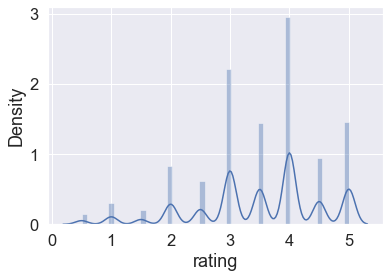

In [50]:
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.distplot(ratings['rating'].fillna(ratings['rating'].median()))

In [52]:
movies['genres'] = movies['genres'].str.split('|')
# Convert genres to string value
movies['genres'] = movies['genres'].fillna("").astype('str')

In [53]:
dataset = pd.merge(movies, ratings)
# Display 20 movies with highest ratings
dataset[['title','genres','rating']].sort_values('rating', ascending=False).head(20)

,title,genres,rating
56251,Eraserhead (1977),"['Drama', 'Horror']",5.0
33888,Chasing Amy (1997),"['Comedy', 'Drama', 'Romance']",5.0
20742,My Fair Lady (1964),"['Comedy', 'Drama', 'Musical', 'Romance']",5.0
10168,Forrest Gump (1994),"['Comedy', 'Drama', 'Romance', 'War']",5.0
10169,Forrest Gump (1994),"['Comedy', 'Drama', 'Romance', 'War']",5.0
65379,Gosford Park (2001),"['Comedy', 'Drama', 'Mystery']",5.0
10171,Forrest Gump (1994),"['Comedy', 'Drama', 'Romance', 'War']",5.0
20739,My Fair Lady (1964),"['Comedy', 'Drama', 'Musical', 'Romance']",5.0
10173,Forrest Gump (1994),"['Comedy', 'Drama', 'Romance', 'War']",5.0
10174,Forrest Gump (1994),"['Comedy', 'Drama', 'Romance', 'War']",5.0


In [77]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [78]:
algo = SVD()
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8709  0.8788  0.8782  0.8721  0.8659  0.8732  0.0048  
MAE (testset)     0.6672  0.6742  0.6720  0.6721  0.6673  0.6706  0.0028  
Fit time          5.01    5.18    5.15    5.07    5.22    5.12    0.08    
Test time         0.16    0.16    0.16    0.25    0.15    0.18    0.04    


In [79]:
print("MAE on Test Set using 5 fold CV", results['test_mae'].mean())
print("RMSE on Test Set using 5 fold CV", results['test_rmse'].mean())

MAE on Test Set using 5 fold CV 0.6705806477196702
RMSE on Test Set using 5 fold CV 0.8731582464270436


In [80]:
# Average MAE and RMSE for Item Base Collaborative Filtering using 5 - Fold CF
sim_options = {
    "user_based": False,
}

knn_m = KNNWithMeans(sim_options=sim_options)
scores = cross_validate(knn_m, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

mean_mae = scores['test_mae'].mean()
mean_rsme = scores['test_rmse'].mean()

print(f'Average MAE: {mean_mae}')
print(f'Average RMSE: {mean_rsme}')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8840  0.8914  0.8980  0.8924  0.8971  0.8926  0.0050  
MAE (testset)     0.6752  0.6819  0.6861  0.6824  0.6853  0.6821  0.0039  
Fit time          5.11    5.08    5.23    5.07    4.99    5.09    0.08    
Test time         9.01    9.56    9.38    9.38    9.08    9.28    0.21    
Average MAE: 0.6821487529535579
Average RMSE: 0.8925634645648988


In [81]:
# Average MAE and RMSE for User Base Collaborative Filtering using 5 - Fold CF
sim_options = {
    "user_based": True,
}

knn_m = KNNWithMeans(sim_options=sim_options)
scores = cross_validate(knn_m, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

mean_mae = scores['test_mae'].mean()
mean_rsme = scores['test_rmse'].mean()

print(f'Average MAE: {mean_mae}')
print(f'Average RMSE: {mean_rsme}')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8925  0.8933  0.8927  0.8972  0.9044  0.8960  0.0045  
MAE (testset)     0.6821  0.6813  0.6816  0.6854  0.6922  0.6845  0.0041  
Fit time          0.23    0.25    0.30    0.25    0.25    0.26    0.02    
Test time         1.86    1.86    1.94    1.88    1.97    1.90    0.05    
Average MAE: 0.6845099634292612
Average RMSE: 0.8960250825604514


In [82]:
# Comparing Cosine, MSD, Pearson Similarities on Item Based CF
similarity_names = ['cosine','msd','pearson']
mean_mae_item = []
mean_rmse_item = []
for name in similarity_names:
  sim_options = {
    "user_based": False,
    "name": name
  }

  knn_m = KNNWithMeans(sim_options=sim_options)
  scores = cross_validate(knn_m, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

  mean_mae_item.append(scores['test_mae'].mean())
  mean_rmse_item.append(scores['test_rmse'].mean())

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9050  0.9105  0.9100  0.9074  0.9029  0.9072  0.0029  
MAE (testset)     0.6913  0.6970  0.6946  0.6923  0.6912  0.6933  0.0022  
Fit time          19.93   19.70   19.65   18.99   19.43   19.54   0.32    
Test time         8.84    8.77    8.86    8.69    8.88    8.81    0.07    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix.

In [83]:
print(f'Similarity Measure: {similarity_names}')
print(f'Average MAE: {mean_mae_item}')
print(f'Average RMSE: {mean_rmse_item}')

Similarity Measure: ['cosine', 'msd', 'pearson']
Average MAE: [0.6932789771934582, 0.6815371358278035, 0.6858151890910503]
Average RMSE: [0.9071837060981004, 0.8914055379022008, 0.9003921250369092]


In [84]:
# Comparing Cosine, MSD, Pearson Similarities on User Based CF
similarity_names = ['cosine','msd','pearson']
mean_mae_user = []
mean_rmse_user = []
for name in similarity_names:
  sim_options = {
    "user_based": True,
    "name": name
  }

  knn_m = KNNWithMeans(sim_options=sim_options)
  scores = cross_validate(knn_m, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

  mean_mae_user.append(scores['test_mae'].mean())
  mean_rmse_user.append(scores['test_rmse'].mean())

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8953  0.8931  0.9061  0.9091  0.8984  0.9004  0.0062  
MAE (testset)     0.6856  0.6845  0.6918  0.6941  0.6903  0.6893  0.0037  
Fit time          0.66    0.76    0.72    0.70    0.70    0.71    0.03    
Test time         2.00    1.93    1.97    2.08    1.86    1.97    0.07    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix.

In [85]:
print(f'Similarity Measure: {similarity_names}')
print(f'Average MAE: {mean_mae_user}')
print(f'Average RMSE: {mean_rmse_user}')

Similarity Measure: ['cosine', 'msd', 'pearson']
Average MAE: [0.6892633891360868, 0.6845657105516479, 0.6822739046739305]
Average RMSE: [0.900421234213605, 0.8958205906188776, 0.8956279458450964]


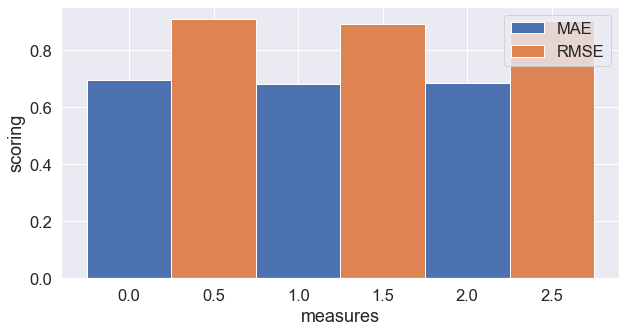

In [86]:
ind = np.arange(len(similarity_names))
plt.figure(figsize=(10,5))
plt.bar(ind, mean_mae_item, 0.5, label='MAE')
plt.bar(ind + 0.5, mean_rmse_item, 0.5, label='RMSE')


plt.xlabel('measures')
plt.ylabel('scoring')


plt.legend(loc='best')
plt.show()


<Figure size 432x288 with 0 Axes>

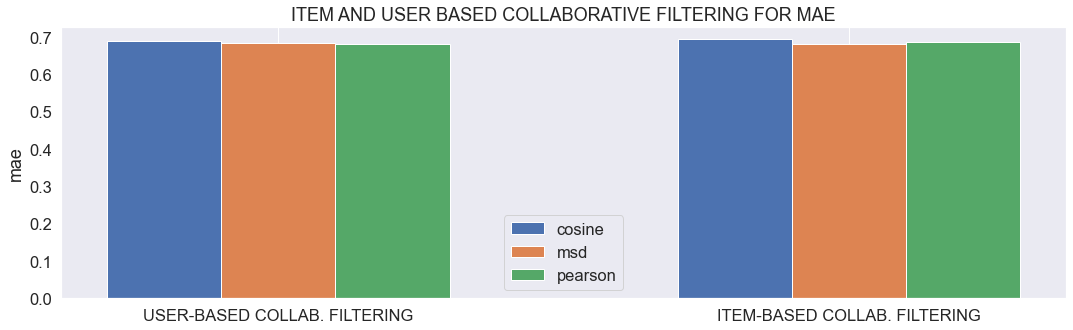

In [87]:
ifig=1
labels = ['USER-BASED COLLAB. FILTERING', 'ITEM-BASED COLLAB. FILTERING']
x = np.arange(0, len(labels) * 2.5, 2.5)
width = 0.5
plt.figure(ifig)
fig, ax = plt.subplots(figsize=(18,5))
for i in range(len(similarity_names)):
    ax.bar(x - (width * len(similarity_names)) / 2 + i * width, [mean_mae_user[i], mean_mae_item[i]], width, label=similarity_names[i])
plt.xticks(x - width / 2, labels)
plt.title('ITEM AND USER BASED COLLABORATIVE FILTERING FOR MAE')
plt.ylabel('mae')
plt.grid(axis='y')
plt.legend()
plt.show()

In [88]:
# Finding impact of k value for user based collaboration
ks = np.arange(1, 20, 1)


ub_mae = []
ub_rmse = []

for k in ks: 
    
    sim_options = {
    "user_based": True, 
    }
    
    
    knn_m = KNNWithMeans(k, sim_options=sim_options)
    scores = cross_validate(knn_m, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    
    
    mean_mae = scores['test_mae'].mean()
    mean_rsme = scores['test_rmse'].mean()
    
   
    ub_mae.append(mean_mae)
    ub_rmse.append(mean_rsme)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1076  1.0962  1.0987  1.1040  1.1145  1.1042  0.0065  
MAE (testset)     0.8544  0.8480  0.8475  0.8530  0.8552  0.8516  0.0032  
Fit time          0.23    0.25    0.25    0.29    0.26    0.26    0.02    
Test time         0.87    0.87    0.90    0.94    1.03    0.92    0.06    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9056  0.9047  0.9110  0.9075  0.8934  0.9044  0.0059  
MAE (testset)     0.6935  0.6958  0.6986  0.6958  0.6841  0.6935  0.0050  
Fit time          0.25    0.25    0.28    0.25    0.29    0.26    0.02    
Test time         1.52    1.65    1.48    1.50    1.64    1.56    0.07    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, 

In [89]:
# Finding impact of k value for item based collaboration
ib_mae = []
ib_rmse = []

for k in ks: 
    sim_options = {
    "user_based": False,  
    }
    
    knn_m = KNNWithMeans(k, sim_options=sim_options)
    scores = cross_validate(knn_m, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    
    mean_mae = scores['test_mae'].mean()
    mean_rsme = scores['test_rmse'].mean()
    
    ib_mae.append(mean_mae)
    ib_rmse.append(mean_rsme)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1423  1.1403  1.1304  1.1385  1.1377  1.1378  0.0041  
MAE (testset)     0.8737  0.8695  0.8623  0.8692  0.8681  0.8686  0.0036  
Fit time          4.91    5.14    5.13    4.91    4.88    4.99    0.12    
Test time         6.41    6.11    6.05    6.23    6.00    6.16    0.15    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9227  0.9128  0.9089  0.9110  0.9139  0.9139  0.0047  
MAE (testset)     0.7038  0.7009  0.6951  0.7000  0.6990  0.6998  0.0028  
Fit time          4.86    5.01    4.96    4.98    4.96    4.95    0.05    
Test time         7.50    8.15    7.70    7.77    7.72    7.77    0.21    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, 

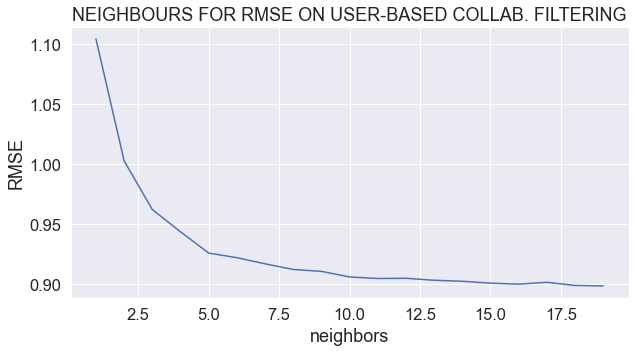

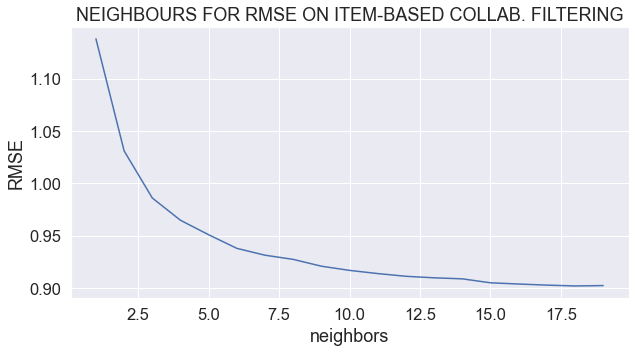

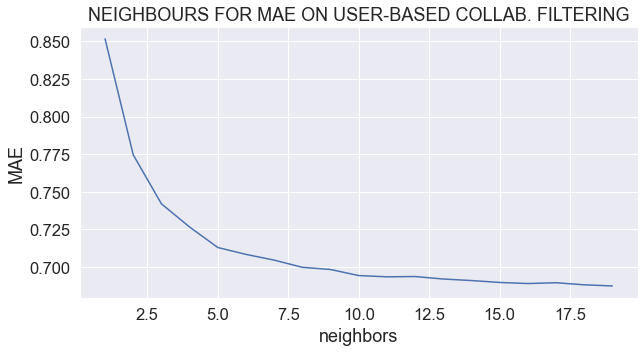

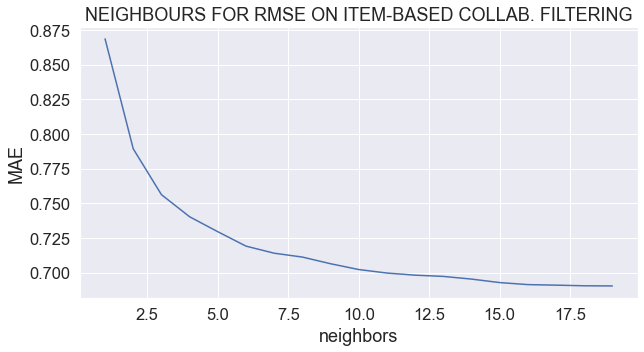

In [90]:
plt.figure(figsize=(10,5))
plt.plot(ks, ub_rmse)
plt.title('NEIGHBOURS FOR RMSE ON USER-BASED COLLAB. FILTERING')
plt.xlabel('neighbors')
plt.ylabel('RMSE')

plt.show()

plt.figure(figsize=(10,5))
plt.plot(ks, ib_rmse)
plt.title('NEIGHBOURS FOR RMSE ON ITEM-BASED COLLAB. FILTERING')
plt.xlabel('neighbors')
plt.ylabel('RMSE')

plt.show()

plt.figure(figsize=(10,5))
plt.plot(ks, ub_mae)
plt.title('NEIGHBOURS FOR MAE ON USER-BASED COLLAB. FILTERING')
plt.xlabel('neighbors')
plt.ylabel('MAE')

plt.show()

plt.figure(figsize=(10,5))
plt.plot(ks, ib_mae)
plt.title('NEIGHBOURS FOR RMSE ON ITEM-BASED COLLAB. FILTERING')
plt.xlabel('neighbors')
plt.ylabel('MAE')


plt.show()

In [91]:
#Showing the best value for K for each collab 
print('USER-BASED COLLAB. FILTERING - MAE')
print('Best K: ', ks[np.argmin(ub_mae)])
print('Best K MAE: ', np.min(ub_mae))

print('\nUSER-BASED COLLAB. FILTERING - RMSE')
print('Best K: ', ks[np.argmin(ub_rmse)])
print('Best K RMSE: ', np.min(ub_rmse))

print('\nITEM-BASED COLLAB. FILTERING - MAE')
print('Best K: ', ks[np.argmin(ib_mae)])
print('Best K MAE: ', np.min(ib_mae))

print('\nITEM-BASED COLLAB. FILTERING - RMSE')
print('Best K: ', ks[np.argmin(ib_rmse)])
print('Best K RMSE: ', np.min(ib_rmse))

USER-BASED COLLAB. FILTERING - MAE
Best K:  19
Best K MAE:  0.6874838010859687

USER-BASED COLLAB. FILTERING - RMSE
Best K:  19
Best K RMSE:  0.8982359188546637

ITEM-BASED COLLAB. FILTERING - MAE
Best K:  19
Best K MAE:  0.6904498861779428

ITEM-BASED COLLAB. FILTERING - RMSE
Best K:  18
Best K RMSE:  0.9020531641806633


In [92]:
#Average MAE and RMSE for User Base Collaborative Filtering using 5 - Fold CF
sim_options = {
    "user_based": True,
    'name':'Cosine'
}

knn_m = KNNWithMeans(k=19, sim_options=sim_options)
scores = cross_validate(knn_m, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

mean_mae = scores['test_mae'].mean()
mean_rsme = scores['test_rmse'].mean()

print(f'Average MAE: {mean_mae}')
print(f'Average RMSE: {mean_rsme}')

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9065  0.8977  0.8934  0.9096  0.9047  0.9024  0.0059  
MAE (testset)     0.6948  0.6921  0.6874  0.6943  0.6932  0.6924  0.0027  
Fit time          0.65    0.66    0.66    0.66    0.68    0.66    0.01    
Test time         1.47    1.44    1.71    1.57    1.58    1.55    0.09    
Average MAE: 0.6923616804684171
Average RMSE: 0.9023918511277167
